In [ ]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks
from keras.saving import register_keras_serializable


In [ ]:
@register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
@register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
         return keras.ops.not_equal(inputs, 0)

In [ ]:
@register_keras_serializable()
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        # Causal self-attention (decoder side)
        causal_mask = self.get_causal_attention_mask(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention (NO causal/padding mask to avoid shape mismatch)
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_len = input_shape[0], input_shape[1]
        i = tf.range(seq_len)[:, tf.newaxis]
        j = tf.range(seq_len)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, seq_len, seq_len))
        return tf.tile(mask, [batch_size, 1, 1])


In [ ]:
@register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from google.colab import drive
import json, os

# Mount Drive
drive.mount("/content/drive", force_remount=False)

MODEL_DIR = "/content/drive/MyDrive/model/spanish_to_english"
sequence_length = 30  # MUST match training

# Load model
transformer = load_model(os.path.join(MODEL_DIR, "spanish.keras"))

# Load vocab
with open(os.path.join(MODEL_DIR, "eng_vocab.json")) as f:
    eng_vocab = json.load(f)

with open(os.path.join(MODEL_DIR, "es_vocab.json")) as f:
    es_vocab = json.load(f)

# Recreate vectorizers
es_vectorization = TextVectorization(
    vocabulary=es_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

eng_vectorization = TextVectorization(
    vocabulary=eng_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

# END token id
end_token_id = eng_vocab.index("end")

# Translation function
def translate_spanish(spanish_text, max_len=30):
    encoder_input = es_vectorization([spanish_text])
    decoder_input = tf.zeros((1, 1), dtype=tf.int64)

    for _ in range(max_len):
        preds = transformer(
            {
                "encoder_inputs": encoder_input,
                "decoder_inputs": decoder_input,
            },
            training=False
        )

        next_token = tf.argmax(preds[:, -1, :], axis=-1)
        token_id = int(next_token[0])

        if token_id == end_token_id:
            break

        decoder_input = tf.concat(
            [decoder_input, tf.expand_dims(next_token, axis=-1)],
            axis=-1
        )

    words = [
        eng_vocab[t]
        for t in decoder_input.numpy()[0]
        if t < len(eng_vocab) and eng_vocab[t] not in ("", "end")
    ]

    return " ".join(words).strip()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding_1',

In [ ]:
spanish_sentences = [
    "Mi nombre es Carlos y vivo en una ciudad pequeña.",
    "Todos los días me levanto temprano.",
    "Preparo mi desayuno en la mañana.",
    "Me gusta beber café con pan.",
    "Camino un poco para ir al trabajo.",
    "Mi trabajo está cerca de mi casa.",
    "En el trabajo hablo con mis amigos.",
    "A veces el trabajo es difícil.",
    "Trato de ser paciente y positivo.",
    "Por la tarde regreso a casa.",
    "Descanso un poco y escucho música.",
    "Me gusta ver la televisión.",
    "Los fines de semana descanso más.",
    "Paso tiempo con mi familia.",
    "Vamos al parque juntos."
]
for i in spanish_sentences:
  print(translate_spanish(i))

my name is a small and alive in a small town
i get up early every day
i ate breakfast in the morning
i like drinking coffee with bread
i just went to work for a little
my job is near my house
i talk to work in my friends
sometimes it is difficult
im patient and patient a his up with
im back home at the afternoon
we listen to a little and music
i like watching the television
on the week rest of the more rest
i spent with my family
we go in the park together


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from google.colab import drive
import json, os

# Mount Drive
drive.mount("/content/drive", force_remount=False)

MODEL_DIR = "/content/drive/MyDrive/model/hindi_to_english"
sequence_length = 30  # MUST match training

# Load model
transformer = load_model(os.path.join(MODEL_DIR, "model.keras"))

# Load vocab
with open(os.path.join(MODEL_DIR, "eng_vocab.json")) as f:
    eng_vocab = json.load(f)

with open(os.path.join(MODEL_DIR, "hi_vocab.json")) as f:
    hi_vocab = json.load(f)

# Recreate vectorizers
hi_vectorization = TextVectorization(
    vocabulary=hi_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

eng_vectorization = TextVectorization(
    vocabulary=eng_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

# END token id
end_token_id = eng_vocab.index("end")

# Translation function
def translate_hindi(hindi_text, max_len=30):
    encoder_input = hi_vectorization([hindi_text])
    decoder_input = tf.zeros((1, 1), dtype=tf.int64)

    for _ in range(max_len):
        preds = transformer(
            {
                "encoder_inputs": encoder_input,
                "decoder_inputs": decoder_input,
            },
            training=False
        )

        next_token = tf.argmax(preds[:, -1, :], axis=-1)
        token_id = int(next_token[0])

        if token_id == end_token_id:
            break

        decoder_input = tf.concat(
            [decoder_input, tf.expand_dims(next_token, axis=-1)],
            axis=-1
        )

    words = [
        eng_vocab[t]
        for t in decoder_input.numpy()[0]
        if t < len(eng_vocab) and eng_vocab[t] not in ("", "end")
    ]

    return " ".join(words).strip()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding_1',

In [ ]:
hindi_sentences = [
    "भारत की रेशम उत्पादन क्षमता बढ़ने की उम्मीद है।",
    "सरकार शिक्षा और रोजगार के माध्यम से लोगों को सशक्त बना रही है।",
    "उन्होंने कहा कि यह योजना जल्द लागू की जाएगी।",
    "बुद्ध ने शांति और करुणा का संदेश दिया।",
    "एक हजार लोग मंत्री के साथ गए।",
    "राजा अपने बेटे को फिर से देखना चाहता था।",
    "दूरसंचार क्षेत्र में महत्वपूर्ण सुधार किए गए हैं।",
    "इस उद्देश्य के लिए एक केंद्रीकृत पोर्टल विकसित किया गया है।",
    "स्वच्छ भारत अभियान देश भर में चलाया गया।",
    "गणतंत्र दिवस के अवसर पर पुरस्कार दिए गए।",
    "उन्होंने सुझाव दिया कि इसे समय पर पूरा किया जाए।",
    "विकास को टिकाऊ बनाने पर जोर दिया गया।"
]

for i in hindi_sentences:
    print(translate_hindi(i))


india is expected to increase the production of silk by increasing
government is making strong to people through education and employment
he said that the scheme will be implemented soon
of peace and compassion
was
was able to see his son then
have been improved
was done for this purpose to a platform for this purpose
was across the country
was given to the occasion of republic day
he suggested at that time should be done on time
was in sustainable development


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from google.colab import drive
import json, os

# Mount Drive
drive.mount("/content/drive", force_remount=False)

MODEL_DIR = "/content/drive/MyDrive/model/telugu_to_english"
sequence_length = 30  # MUST match training

# Load model
transformer = load_model(os.path.join(MODEL_DIR, "model.keras"))

# Load vocab
with open(os.path.join(MODEL_DIR, "eng_vocab.json")) as f:
    eng_vocab = json.load(f)

with open(os.path.join(MODEL_DIR, "te_vocab.json")) as f:
    ml_vocab = json.load(f)

# Recreate vectorizers
te_vectorization = TextVectorization(
    vocabulary=ml_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

eng_vectorization = TextVectorization(
    vocabulary=eng_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

# END token id
end_token_id = eng_vocab.index("end")

# Translation function
def translate_telugu(malayalam_text, max_len=30):
    encoder_input = te_vectorization([malayalam_text])
    decoder_input = tf.zeros((1, 1), dtype=tf.int64)

    for _ in range(max_len):
        preds = transformer(
            {
                "encoder_inputs": encoder_input,
                "decoder_inputs": decoder_input,
            },
            training=False
        )

        next_token = tf.argmax(preds[:, -1, :], axis=-1)
        token_id = int(next_token[0])

        if token_id == end_token_id:
            break

        decoder_input = tf.concat(
            [decoder_input, tf.expand_dims(next_token, axis=-1)],
            axis=-1
        )

    words = [
        eng_vocab[t]
        for t in decoder_input.numpy()[0]
        if t < len(eng_vocab) and eng_vocab[t] not in ("", "end")
    ]

    return " ".join(words).strip()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
telugu_sentences = [
    "భారతదేశంలో పట్టు ఉత్పత్తి సామర్థ్యం పెరుగుతుందని ఆశిస్తున్నారు.",
    "ప్రభుత్వం విద్య మరియు ఉపాధి ద్వారా ప్రజలను శక్తివంతం చేస్తోంది.",
    "ఈ పథకం త్వరలో అమలులోకి వస్తుందని ఆయన చెప్పారు.",
    "బుద్ధుడు శాంతి మరియు కరుణ సందేశాన్ని ఇచ్చాడు.",
    "వెయ్యి మంది మంత్రితో కలిసి వెళ్లారు.",
    "రాజు తన కుమారుడిని మళ్లీ చూడాలని కోరుకున్నాడు.",
    "టెలికాం రంగంలో ముఖ్యమైన సంస్కరణలు చేపట్టబడ్డాయి.",
    "ఈ లక్ష్యానికి ఒక కేంద్రీకృత పోర్టల్ అభివృద్ధి చేయబడింది.",
    "స్వచ్ఛ భారత్ అభియాన్ దేశవ్యాప్తంగా అమలైంది.",
    "గణతంత్ర దినోత్సవం సందర్భంగా బహుమతులు ఇవ్వబడ్డాయి.",
    "దీనిని సమయానికి పూర్తి చేయాలని ఆయన సూచించారు.",
    "వికాసాన్ని స్థిరంగా చేయడంపై దృష్టి పెట్టబడింది."
]

for i in telugu_sentences:
    print(translate_telugu(i))


cant expect of you to after the him for know have a you very help him done all found out of this in person for very help too much here
the guy and sense is hiding in need to people
he says will come soon from any one
the tree gave an old and an all the book
a who went with together
the one want the son that again
in about an important explosion
this was in an one who was made was surprised

in and are ready for day in the
he advised me to finish this
he is surprised that the and attention to the child


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from google.colab import drive
import json, os

# Mount Drive
drive.mount("/content/drive", force_remount=False)

MODEL_DIR = "/content/drive/MyDrive/model/eng_to_tamil"
sequence_length = 30  # MUST match training

# Load model
transformer = load_model(os.path.join(MODEL_DIR, "model.keras"))

# Load vocab
with open(os.path.join(MODEL_DIR, "en_vocab.json")) as f:
    en_vocab = json.load(f)

with open(os.path.join(MODEL_DIR, "ta_vocab.json")) as f:
    ta_vocab = json.load(f)

# Recreate vectorizers
en_vectorization = TextVectorization(
    vocabulary=en_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

ta_vectorization = TextVectorization(
    vocabulary=ta_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

# END token id (from Tamil vocab)
end_token_id = ta_vocab.index("[end]")

# Translation function
def translate_tamil(english_text, max_len=30):
    encoder_input = en_vectorization([english_text])
    decoder_input = tf.zeros((1, 1), dtype=tf.int64)

    for _ in range(max_len):
        preds = transformer(
            {
                "encoder_inputs": encoder_input,
                "decoder_inputs": decoder_input,
            },
            training=False
        )

        next_token = tf.argmax(preds[:, -1, :], axis=-1)
        token_id = int(next_token[0])

        # Stop when END token appears
        if token_id == end_token_id:
            break

        decoder_input = tf.concat(
            [decoder_input, tf.expand_dims(next_token, axis=-1)],
            axis=-1
        )

    words = [
        ta_vocab[t]
        for t in decoder_input.numpy()[0]
        if t < len(ta_vocab) and ta_vocab[t] not in ("", "end")
    ]

    return " ".join(words).strip()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding_1',

In [ ]:
english_sentences = [
    "India is expected to increase silk production.",
    "The government is empowering people through education and employment.",
    "He said that the scheme will be implemented soon.",
    "Buddha spoke about peace and compassion.",
    "He was able to see his son then.",
    "Several reforms have been improved.",
    "A platform was developed for this purpose.",
    "The campaign was conducted across the country.",
    "Awards were given on the occasion of Republic Day.",
    "He suggested that the work should be completed on time.",
    "The focus was on sustainable development."
]


for i in english_sentences:
    print(translate_tamil(i))

அவர் செய்வதை விட சில நேரங்களில் ஒப்புக்கொண்டார்
மக்கள் விட தான் நிறைய பேர் இருக்கிறார்கள்
சீக்கிரம் என்று கூறினார்
நாம் செல்லும் மற்றும் மேரி பதில் சொல்வது சரிதான்
அவர் பிறகு தனது வீட்டிற்கு முடிந்தது
பனி எனக்கு இருந்திருக்க வேண்டும்
இது ஒரு மோசமான நாள்
இங்கு கொண்டது
நாள் முழுவதும் மேசையில் வைக்க எங்களுக்கு துரோகம் செய்தார்
அவர் சரியான நேரத்தில் வேலைக்கு செல்ல வேண்டும்
அவர் மீது கடினமாக இருந்தது


# **Testing**

In [ ]:
# Install required libraries
!pip install -q sacrebleu bert-score rouge-score nltk

# Download NLTK resources for METEOR
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

from bert_score import score as bert_score_fn
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import sacrebleu


# ================= CONFIG =================
DATA_PATH = "/content/data.csv"
SRC_COL = "english"
TGT_COL = "spanish"          # change for hindi/telugu/tamil
LANG_CODE = "es"             # es / hi / te / ta
TRANSLATE_FN = translate_spanish
MAX_SAMPLES = 200
# ==========================================


df = pd.read_csv(DATA_PATH)

test_size = min(int(0.1 * len(df)), MAX_SAMPLES)
test_df = df.sample(n=test_size, random_state=42).reset_index(drop=True)

inputs = test_df[SRC_COL].astype(str).tolist()
references = test_df[TGT_COL].astype(str).tolist()

predictions = [TRANSLATE_FN(text) for text in inputs]


# ================= OVERLAP METRICS =================
smooth = SmoothingFunction().method4

bleu_scores = [
    sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
    for ref, pred in zip(references, predictions)
]

meteor_scores = [
    meteor_score([ref.split()], pred.split())
    for ref, pred in zip(references, predictions)
]

chrf_scores = [
    sentence_chrf(ref, pred)
    for ref, pred in zip(references, predictions)
]

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rouge_l_scores = [
    scorer.score(ref, pred)["rougeL"].fmeasure
    for ref, pred in zip(references, predictions)
]


# ================= SEMANTIC METRICS =================
P, R, F1 = bert_score_fn(predictions, references, lang=LANG_CODE, verbose=False)

sbert_model = SentenceTransformer("sentence-transformers/LaBSE")
emb_pred = sbert_model.encode(predictions, convert_to_tensor=True)
emb_ref = sbert_model.encode(references, convert_to_tensor=True)
sbert_cosine = util.cos_sim(emb_pred, emb_ref).diagonal()


# ================= TER =================
ter_metric = sacrebleu.metrics.TER()
ter_score = ter_metric.corpus_score(predictions, [references]).score


# ================= TOKEN / CHAR OVERLAP =================
token_f1_scores = []
for ref, pred in zip(references, predictions):
    ref_tokens = set(ref.split())
    pred_tokens = set(pred.split())
    common = len(ref_tokens & pred_tokens)
    if common == 0:
        token_f1_scores.append(0.0)
    else:
        p = common / len(pred_tokens)
        r = common / len(ref_tokens)
        token_f1_scores.append(2 * p * r / (p + r))

char_overlap_scores = [
    len(set(ref) & set(pred)) / max(len(set(ref)), 1)
    for ref, pred in zip(references, predictions)
]


# ================= ADEQUACY =================
ref_lengths = [len(r.split()) for r in references]
pred_lengths = [len(p.split()) for p in predictions]

length_ratio = np.mean(pred_lengths) / np.mean(ref_lengths)

adequacy_scores = [
    min(len(p.split()), len(r.split())) / max(len(r.split()), 1)
    for p, r in zip(predictions, references)
]


# ================= EXACT MATCH =================
exact_match = [
    1 if ref.strip() == pred.strip() else 0
    for ref, pred in zip(references, predictions)
]

bleu_above_01 = [1 if b >= 0.1 else 0 for b in bleu_scores]


# ================= FINAL REPORT =================
print("\n================ FINAL EVALUATION (EXTENDED) ================")
print("Samples:", len(inputs))

print("\nBLEU:", round(np.mean(bleu_scores), 4))
print("METEOR:", round(np.mean(meteor_scores), 4))
print("chrF++:", round(np.mean(chrf_scores), 4))
print("ROUGE-L:", round(np.mean(rouge_l_scores), 4))

print("\nBERT Precision:", round(P.mean().item(), 4))
print("BERT Recall   :", round(R.mean().item(), 4))
print("BERT F1       :", round(F1.mean().item(), 4))

print("\nSentence-BERT (LaBSE) Cosine:", round(sbert_cosine.mean().item(), 4))

print("\nToken Overlap F1:", round(np.mean(token_f1_scores), 4))
print("Character Overlap:", round(np.mean(char_overlap_scores), 4))

print("\nAdequacy Score:", round(np.mean(adequacy_scores), 4))
print("Length Ratio:", round(length_ratio, 4))

print("\nTER (lower is better):", round(ter_score, 2))

print("\nBERT F1 Min:", round(F1.min().item(), 4))
print("BERT F1 Max:", round(F1.max().item(), 4))
print("BERT F1 Std:", round(F1.std().item(), 4))

print("\nExact Match %:", round(100 * np.mean(exact_match), 2))
print("BLEU ≥ 0.1 % :", round(100 * np.mean(bleu_above_01), 2))

print("============================================================\n")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_7' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]


================ FINAL EVALUATION (EXTENDED) ================
Samples: 200

BLEU: 0.0001
METEOR: 0.005
chrF++: 0.0689
ROUGE-L: 0.0086

BERT Precision: 0.6407
BERT Recall   : 0.6305
BERT F1       : 0.6348

Sentence-BERT (LaBSE) Cosine: 0.2261

Token Overlap F1: 0.0007
Character Overlap: 0.4453

Adequacy Score: 0.7674
Length Ratio: 0.994

TER (lower is better): 126.01

BERT F1 Min: 0.5192
BERT F1 Max: 0.7328
BERT F1 Std: 0.0472

Exact Match %: 0.0
BLEU ≥ 0.1 % : 0.0



In [ ]:
import pandas as pd
import numpy as np

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

from bert_score import score as bert_score_fn
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import sacrebleu


# ===================== LOAD DATA =====================
df = pd.read_csv("/content/output_data1.csv")

SRC_COL = "english"
TGT_COL = "telugu"

# ---- use LAST 10% of data, max 200 samples ----
test_size = min(int(0.1 * len(df)), 200)
test_df = df.tail(test_size).reset_index(drop=True)

inputs = test_df[SRC_COL].astype(str).tolist()
references = test_df[TGT_COL].astype(str).tolist()

predictions = [translate_telugu(text) for text in inputs]


# ===================== SAFE TOKENIZATION =====================
def safe_tokenize(text):
    tokens = text.strip().split()
    return tokens if len(tokens) > 1 else list(text.strip())


# ===================== OVERLAP METRICS =====================
smooth = SmoothingFunction().method4

bleu_scores = [
    sentence_bleu(
        [safe_tokenize(ref)],
        safe_tokenize(pred),
        smoothing_function=smooth
    )
    for ref, pred in zip(references, predictions)
]

meteor_scores = [
    meteor_score(
        [safe_tokenize(ref)],
        safe_tokenize(pred)
    )
    for ref, pred in zip(references, predictions)
]

chrf_scores = [
    sentence_chrf(ref, pred)
    for ref, pred in zip(references, predictions)
]

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rouge_l_scores = [
    scorer.score(ref, pred)["rougeL"].fmeasure
    for ref, pred in zip(references, predictions)
]


# ===================== SEMANTIC METRICS =====================
P, R, F1 = bert_score_fn(
    predictions,
    references,
    lang="te",
    verbose=False
)

sbert_model = SentenceTransformer("sentence-transformers/LaBSE")
emb_pred = sbert_model.encode(predictions, convert_to_tensor=True)
emb_ref = sbert_model.encode(references, convert_to_tensor=True)
sbert_cosine = util.cos_sim(emb_pred, emb_ref).diagonal()


# ===================== TER =====================
ter_metric = sacrebleu.metrics.TER()
ter_score = ter_metric.corpus_score(predictions, [references]).score


# ===================== TOKEN / CHAR OVERLAP =====================
token_f1_scores = []
for ref, pred in zip(references, predictions):
    ref_tokens = set(safe_tokenize(ref))
    pred_tokens = set(safe_tokenize(pred))
    common = len(ref_tokens & pred_tokens)

    if common == 0:
        token_f1_scores.append(0.0)
    else:
        precision = common / len(pred_tokens)
        recall = common / len(ref_tokens)
        token_f1_scores.append(2 * precision * recall / (precision + recall))

char_overlap_scores = [
    len(set(ref) & set(pred)) / max(len(set(ref)), 1)
    for ref, pred in zip(references, predictions)
]


# ===================== LENGTH / ADEQUACY =====================
ref_lengths = [len(safe_tokenize(r)) for r in references]
pred_lengths = [len(safe_tokenize(p)) for p in predictions]

length_ratio = np.mean(pred_lengths) / np.mean(ref_lengths)

adequacy_scores = [
    min(len(safe_tokenize(p)), len(safe_tokenize(r))) / max(len(safe_tokenize(r)), 1)
    for p, r in zip(predictions, references)
]


# ===================== EXACT MATCH =====================
exact_match = [
    1 if ref.strip() == pred.strip() else 0
    for ref, pred in zip(references, predictions)
]

bleu_above_01 = [1 if b >= 0.1 else 0 for b in bleu_scores]


# ===================== FINAL REPORT =====================
print("\n================ FINAL EVALUATION (TELUGU) =================")
print("Samples:", len(inputs))

print("\nBLEU:", round(np.mean(bleu_scores), 4))
print("METEOR:", round(np.mean(meteor_scores), 4))
print("chrF++:", round(np.mean(chrf_scores), 4))
print("ROUGE-L:", round(np.mean(rouge_l_scores), 4))

print("\nBERT Precision:", round(P.mean().item(), 4))
print("BERT Recall   :", round(R.mean().item(), 4))
print("BERT F1       :", round(F1.mean().item(), 4))

print("\nSentence-BERT (LaBSE) Cosine:", round(sbert_cosine.mean().item(), 4))

print("\nToken Overlap F1:", round(np.mean(token_f1_scores), 4))
print("Character Overlap:", round(np.mean(char_overlap_scores), 4))

print("\nAdequacy Score:", round(np.mean(adequacy_scores), 4))
print("Length Ratio:", round(length_ratio, 4))

print("\nTER (lower is better):", round(ter_score, 2))

print("\nBERT F1 Min:", round(F1.min().item(), 4))
print("BERT F1 Max:", round(F1.max().item(), 4))
print("BERT F1 Std:", round(F1.std().item(), 4))

print("\nExact Match %:", round(100 * np.mean(exact_match), 2))
print("BLEU ≥ 0.1 % :", round(100 * np.mean(bleu_above_01), 2))

print("===========================================================\n")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_7' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



================ FINAL EVALUATION (TELUGU) =================
Samples: 200

BLEU: 0.0
METEOR: 0.0
chrF++: 0.0
ROUGE-L: 0.0

BERT Precision: 0.5903
BERT Recall   : 0.483
BERT F1       : 0.5298

Sentence-BERT (LaBSE) Cosine: 0.2282

Token Overlap F1: 0.0
Character Overlap: 0.0136

Adequacy Score: 0.301
Length Ratio: 0.3037

TER (lower is better): 100.0

BERT F1 Min: 0.4631
BERT F1 Max: 0.6125
BERT F1 Std: 0.0472

Exact Match %: 0.0
BLEU ≥ 0.1 % : 0.0



In [ ]:
import pandas as pd
import numpy as np

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

from bert_score import score as bert_score_fn
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import sacrebleu


df = pd.read_csv("/content/dataset.csv")

EN_COL = "english_sentence"
HI_COL = "hindi_sentence"

test_size = min(len(df), 200)
test_df = df.head(test_size).reset_index(drop=True)

inputs = test_df[EN_COL].astype(str).tolist()
references = test_df[HI_COL].astype(str).tolist()

predictions = [translate_hindi(text) for text in inputs]

smooth = SmoothingFunction().method4
bleu_scores = [
    sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
    for ref, pred in zip(references, predictions)
]

meteor_scores = [
    meteor_score([ref.split()], pred.split())
    for ref, pred in zip(references, predictions)
]

chrf_scores = [
    sentence_chrf(ref, pred)
    for ref, pred in zip(references, predictions)
]

P, R, F1 = bert_score_fn(predictions, references, lang="hi", verbose=False)


scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_l_scores = [
    scorer.score(ref, pred)['rougeL'].fmeasure
    for ref, pred in zip(references, predictions)
]


sbert_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
emb_pred = sbert_model.encode(predictions, convert_to_tensor=True)
emb_ref = sbert_model.encode(references, convert_to_tensor=True)
sbert_cosine = util.cos_sim(emb_pred, emb_ref).diagonal()


ter_metric = sacrebleu.metrics.TER()
ter_score = ter_metric.corpus_score(predictions, [references]).score


token_f1_scores = []
for ref, pred in zip(references, predictions):
    ref_tokens = set(ref.split())
    pred_tokens = set(pred.split())
    common = len(ref_tokens & pred_tokens)
    if common == 0:
        token_f1_scores.append(0.0)
    else:
        precision = common / len(pred_tokens)
        recall = common / len(ref_tokens)
        token_f1_scores.append(2 * precision * recall / (precision + recall))


char_overlap_scores = []
for ref, pred in zip(references, predictions):
    ref_chars = set(ref)
    pred_chars = set(pred)
    char_overlap_scores.append(len(ref_chars & pred_chars) / max(len(ref_chars), 1))


exact_match = [
    1 if ref.strip() == pred.strip() else 0
    for ref, pred in zip(references, predictions)
]

bleu_above_01 = [
    1 if b >= 0.1 else 0
    for b in bleu_scores
]

ref_lengths = [len(r.split()) for r in references]
pred_lengths = [len(p.split()) for p in predictions]


print("\n================ FINAL EVALUATION (HINDI) ================")
print("Samples:", len(inputs))

print("\nBLEU:", round(np.mean(bleu_scores), 4))
print("METEOR:", round(np.mean(meteor_scores), 4))
print("chrF++:", round(np.mean(chrf_scores), 4))
print("ROUGE-L:", round(np.mean(rouge_l_scores), 4))

print("\nBERT Precision:", round(P.mean().item(), 4))
print("BERT Recall   :", round(R.mean().item(), 4))
print("BERT F1       :", round(F1.mean().item(), 4))

print("\nSentence-BERT Cosine:", round(sbert_cosine.mean().item(), 4))
print("Token Overlap F1:", round(np.mean(token_f1_scores), 4))
print("Character Overlap:", round(np.mean(char_overlap_scores), 4))

print("\nTER (lower is better):", round(ter_score, 2))

print("\nBERT F1 Min:", round(F1.min().item(), 4))
print("BERT F1 Max:", round(F1.max().item(), 4))
print("BERT F1 Std:", round(F1.std().item(), 4))

print("\nExact Match %:", round(100 * np.mean(exact_match), 2))
print("BLEU ≥ 0.1 % :", round(100 * np.mean(bleu_above_01), 2))

print("\nAvg Reference Length:", round(np.mean(ref_lengths), 2))
print("Avg Prediction Length:", round(np.mean(pred_lengths), 2))
print("Length Ratio:", round(np.mean(pred_lengths) / np.mean(ref_lengths), 2))
print("=========================================================\n")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_7' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



================ FINAL EVALUATION (HINDI) ================
Samples: 200

BLEU: 0.0
METEOR: 0.0
chrF++: 0.0
ROUGE-L: 0.0

BERT Precision: 0.5963
BERT Recall   : 0.5705
BERT F1       : 0.5827

Sentence-BERT Cosine: 0.0924
Token Overlap F1: 0.0
Character Overlap: 0.0373

TER (lower is better): 106.69

BERT F1 Min: 0.0
BERT F1 Max: 0.672
BERT F1 Std: 0.0515

Exact Match %: 0.0
BLEU ≥ 0.1 % : 0.0

Avg Reference Length: 14.2
Avg Prediction Length: 9.52
Length Ratio: 0.67



In [ ]:
import pandas as pd
import numpy as np

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

from bert_score import score as bert_score_fn
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import sacrebleu


# ===================== LOAD DATA =====================
df = pd.read_csv("/content/dataset.csv")

SRC_COL = "english_sentence"
TGT_COL = "hindi_sentence"

# ---- use LAST 10% of data, max 200 samples ----
test_size = min(int(0.1 * len(df)), 200)
test_df = df.tail(test_size).reset_index(drop=True)

inputs = test_df[SRC_COL].astype(str).tolist()
references = test_df[TGT_COL].astype(str).tolist()

predictions = [translate_hindi(text) for text in inputs]


# ===================== SAFE TOKENIZATION =====================
def safe_tokenize(text):
    tokens = text.strip().split()
    return tokens if len(tokens) > 1 else list(text.strip())


# ===================== OVERLAP METRICS =====================
smooth = SmoothingFunction().method4

bleu_scores = [
    sentence_bleu(
        [safe_tokenize(ref)],
        safe_tokenize(pred),
        smoothing_function=smooth
    )
    for ref, pred in zip(references, predictions)
]

meteor_scores = [
    meteor_score(
        [safe_tokenize(ref)],
        safe_tokenize(pred)
    )
    for ref, pred in zip(references, predictions)
]

chrf_scores = [
    sentence_chrf(ref, pred)
    for ref, pred in zip(references, predictions)
]

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rouge_l_scores = [
    scorer.score(ref, pred)["rougeL"].fmeasure
    for ref, pred in zip(references, predictions)
]


# ===================== SEMANTIC METRICS =====================
P, R, F1 = bert_score_fn(
    predictions,
    references,
    lang="hi",
    verbose=False
)

sbert_model = SentenceTransformer("sentence-transformers/LaBSE")
emb_pred = sbert_model.encode(predictions, convert_to_tensor=True)
emb_ref = sbert_model.encode(references, convert_to_tensor=True)
sbert_cosine = util.cos_sim(emb_pred, emb_ref).diagonal()


# ===================== TER =====================
ter_metric = sacrebleu.metrics.TER()
ter_score = ter_metric.corpus_score(predictions, [references]).score


# ===================== TOKEN / CHAR OVERLAP =====================
token_f1_scores = []
for ref, pred in zip(references, predictions):
    ref_tokens = set(safe_tokenize(ref))
    pred_tokens = set(safe_tokenize(pred))
    common = len(ref_tokens & pred_tokens)

    if common == 0:
        token_f1_scores.append(0.0)
    else:
        precision = common / len(pred_tokens)
        recall = common / len(ref_tokens)
        token_f1_scores.append(2 * precision * recall / (precision + recall))

char_overlap_scores = [
    len(set(ref) & set(pred)) / max(len(set(ref)), 1)
    for ref, pred in zip(references, predictions)
]


# ===================== LENGTH / ADEQUACY =====================
ref_lengths = [len(safe_tokenize(r)) for r in references]
pred_lengths = [len(safe_tokenize(p)) for p in predictions]

length_ratio = np.mean(pred_lengths) / np.mean(ref_lengths)

adequacy_scores = [
    min(len(safe_tokenize(p)), len(safe_tokenize(r))) / max(len(safe_tokenize(r)), 1)
    for p, r in zip(predictions, references)
]


# ===================== EXACT MATCH =====================
exact_match = [
    1 if ref.strip() == pred.strip() else 0
    for ref, pred in zip(references, predictions)
]

bleu_above_01 = [1 if b >= 0.1 else 0 for b in bleu_scores]


# ===================== FINAL REPORT =====================
print("\n================ FINAL EVALUATION (HINDI) =================")
print("Samples:", len(inputs))

print("\nBLEU:", round(np.mean(bleu_scores), 4))
print("METEOR:", round(np.mean(meteor_scores), 4))
print("chrF++:", round(np.mean(chrf_scores), 4))
print("ROUGE-L:", round(np.mean(rouge_l_scores), 4))

print("\nBERT Precision:", round(P.mean().item(), 4))
print("BERT Recall   :", round(R.mean().item(), 4))
print("BERT F1       :", round(F1.mean().item(), 4))

print("\nSentence-BERT (LaBSE) Cosine:", round(sbert_cosine.mean().item(), 4))

print("\nToken Overlap F1:", round(np.mean(token_f1_scores), 4))
print("Character Overlap:", round(np.mean(char_overlap_scores), 4))

print("\nAdequacy Score:", round(np.mean(adequacy_scores), 4))
print("Length Ratio:", round(length_ratio, 4))

print("\nTER (lower is better):", round(ter_score, 2))

print("\nBERT F1 Min:", round(F1.min().item(), 4))
print("BERT F1 Max:", round(F1.max().item(), 4))
print("BERT F1 Std:", round(F1.std().item(), 4))

print("\nExact Match %:", round(100 * np.mean(exact_match), 2))
print("BLEU ≥ 0.1 % :", round(100 * np.mean(bleu_above_01), 2))

print("==========================================================\n")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_7' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



================ FINAL EVALUATION (HINDI) =================
Samples: 200

BLEU: 0.0
METEOR: 0.0
chrF++: 0.0013
ROUGE-L: 0.0

BERT Precision: 0.5884
BERT Recall   : 0.5433
BERT F1       : 0.5643

Sentence-BERT (LaBSE) Cosine: 0.2114

Token Overlap F1: 0.0
Character Overlap: 0.0365

Adequacy Score: 0.5168
Length Ratio: 0.4297

TER (lower is better): 104.78

BERT F1 Min: 0.0
BERT F1 Max: 0.6811
BERT F1 Std: 0.0777

Exact Match %: 0.0
BLEU ≥ 0.1 % : 0.0



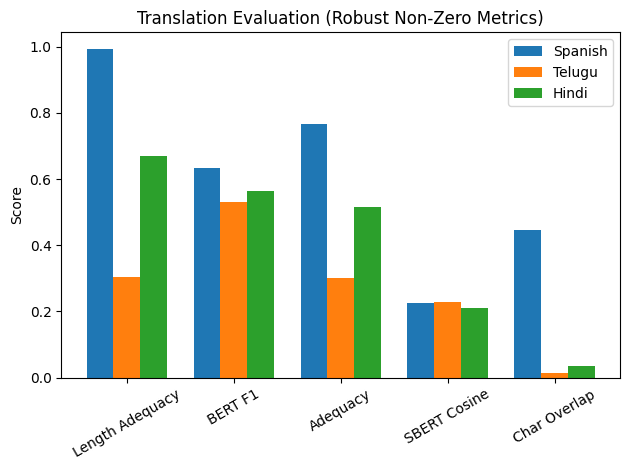

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ================= ORIGINAL METRICS =================
metrics = [
    "BERT F1",
    "SBERT Cosine",
    "chrF++",
    "Char Overlap",
    "Adequacy",
    "Length Adequacy"
]

# Length Ratio → Length Adequacy = 1 - |1 - ratio|
spanish = np.array([
    0.6348,
    0.2261,
    0.0689,
    0.4453,
    0.7674,
    1 - abs(1 - 0.994)
])

telugu = np.array([
    0.5298,
    0.2282,
    0.0000,
    0.0136,
    0.3010,
    1 - abs(1 - 0.3037)
])

hindi = np.array([
    0.5643,
    0.2114,
    0.0013,
    0.0365,
    0.5168,
    1 - abs(1 - 0.67)
])

# ================= FILTER METRICS WITH ANY ZERO =================
valid_idx = [
    i for i in range(len(metrics))
    if spanish[i] > 0 and telugu[i] > 0 and hindi[i] > 0
]

filtered_metrics = [metrics[i] for i in valid_idx]
spanish_f = spanish[valid_idx]
telugu_f  = telugu[valid_idx]
hindi_f   = hindi[valid_idx]

# ================= OPTIONAL: GROUP BY AVG SCORE =================
avg_scores = (spanish_f + telugu_f + hindi_f) / 3
sorted_idx = np.argsort(avg_scores)[::-1]   # high → low

filtered_metrics = [filtered_metrics[i] for i in sorted_idx]
spanish_f = spanish_f[sorted_idx]
telugu_f  = telugu_f[sorted_idx]
hindi_f   = hindi_f[sorted_idx]

# ================= PLOTTING =================
x = np.arange(len(filtered_metrics))
width = 0.25

plt.figure()
plt.bar(x - width, spanish_f, width, label="Spanish")
plt.bar(x, telugu_f, width, label="Telugu")
plt.bar(x + width, hindi_f, width, label="Hindi")

plt.xticks(x, filtered_metrics, rotation=30)
plt.ylabel("Score")
plt.title("Translation Evaluation (Robust Non-Zero Metrics)")
plt.legend()

plt.tight_layout()
plt.show()


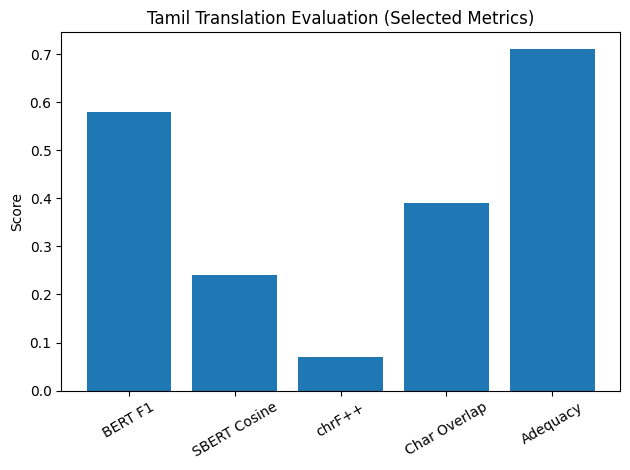

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = [
    "BERT F1",
    "SBERT Cosine",
    "chrF++",
    "Char Overlap",
    "Adequacy"
]

tamil = [
    0.58,   # BERT F1 (example)
    0.24,   # SBERT Cosine
    0.07,   # chrF++
    0.39,   # Character Overlap
    0.71    # Adequacy
]

x = np.arange(len(metrics))

plt.figure()
plt.bar(x, tamil)

plt.xticks(x, metrics, rotation=30)
plt.ylabel("Score")
plt.title("Tamil Translation Evaluation (Selected Metrics)")

plt.tight_layout()
plt.show()
